# W207 Final Project: Facial Recognition

### Team: MapReduce, MapReuse, MapRecycle
Members: Tennison Yu, Madeleine Bulkow, Mark Paluta, Alex Dauenhauer

https://github.com/tyu0912/207_facial_recognition/tree/master
https://github.com/tyu0912/MIDS_W207_facial_recognition/issues

## Introduction

This is the final project submission from Team MapReduce,MapReuse,MapRecycle for W207: Applied Machine Learning as part of the MIDS program at UC Berkeley. We are working with data from https://www.kaggle.com/c/facial-keypoints-detection/data and the goal is to accurately identify facial features on an (x, y) coordinate system based on an input image. 


*Ideas to try*
- Use other features to predict one specific feature
- Break out the image into its own matrix where each pixel is a feature and then predict each facial characteristic position
    - First use subset of images that contain all key points and then just predict the locations. 

*Knockout List/Plan*
- Prepare a summary table of quality metrics: L2 distance, L1 distance
- use graphviz feature to visualize the model - ALEX
- How does samples size / filter number / number of layers affect performance?

*Things to think about*
- separate augmented data sets as well as full data set of all augmentations
- Possible DOE for toggling features

*Naming/Working Rules*
- train_data, train_labels
- dev_data, dev_labels
- Feature Engineering: put "_transformation done". Ex: train_data_blur

*Useful Items*
- Learn Keras
- https://www.kaggle.com/c/facial-keypoints-detection#getting-started-with-r
- http://adventuresinmachinelearning.com/keras-tutorial-cnn-11-lines/
- https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm#k-NN_regression
- http://www.eurecom.fr/en/publication/4768/download/mm-publi-4768.pdf
- https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/

*Tennison Merge Notes*
- Need to make the output part of the algorithm
- The simple algorithm part needs to be fleshed out. Hyperparameter tuning?
- More transformations perhaps?
- Do we still want to do the simple neural net?
- Do we still want to play around with having more graphs to show training time, etc. 

## Data 

### Loading datasets and packages

keep import cell
- plan is to split train and dev data and use `validation_data` in fit

In [12]:
# Optional cell to install/update all required packages
! pip install keras tensorflow numpy pandas matplotlib scipy imgaug opencv-python > nul
print('Packages installed, output supressed for cleanliness')

Packages installed, output supressed for cleanliness


In [1]:
import time, os, keras, tensorflow as tf, decimal, warnings, imgaug as ia
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.utils import shuffle
from keras import backend as K
from keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D
from keras.models import Sequential
from keras.utils import plot_model
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import GridSearchCV
from scipy import stats
from imgaug import augmenters as iaa

# set tensorflow as keras backend
if K.backend() != "tensorflow":
    os.environ['KERAS_BACKEND'] = "tensorflow"
    reload(K)

print('keras version:', keras.__version__)
print('tensorflow version:', tf.__version__)
print('pandas version:', pd.__version__)
print('numpy version:', np.__version__)

# Initiate settings and load the data.
np.random.seed(0)
pd.options.display.max_columns = 30
warnings.filterwarnings('ignore')

train = pd.read_csv('training.csv')
test = pd.read_csv('test.csv')
features = train.columns[:-1]

Using TensorFlow backend.


keras version: 2.2.4
tensorflow version: 1.12.0
pandas version: 0.22.0
numpy version: 1.15.4


### Glancing at the Data

In [13]:
print('Sample Training Labels')
train[train.columns[:-1]].head(5)

Sample Training Labels


,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,right_eye_outer_corner_x,right_eye_outer_corner_y,left_eyebrow_inner_end_x,left_eyebrow_inner_end_y,left_eyebrow_outer_end_x,left_eyebrow_outer_end_y,right_eyebrow_inner_end_x,right_eyebrow_inner_end_y,right_eyebrow_outer_end_x,right_eyebrow_outer_end_y,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y
0,66.033564,39.002274,30.227008,36.421678,59.582075,39.647423,73.130346,39.969997,36.356571,37.389402,23.452872,37.389402,56.953263,29.033648,80.227128,32.228138,40.227609,29.002322,16.356379,29.647471,44.420571,57.066803,61.195308,79.970165,28.614496,77.388992,43.312602,72.935459,43.130707,84.485774
1,64.332936,34.970077,29.949277,33.448715,58.856170,35.274349,70.722723,36.187166,36.034723,34.361532,24.472511,33.144443,53.987404,28.275949,78.634213,30.405923,42.728851,26.146043,16.865362,27.058860,48.206298,55.660936,56.421447,76.352000,35.122383,76.047660,46.684596,70.266553,45.467915,85.480170
2,65.057053,34.909642,30.903789,34.909642,59.412000,36.320968,70.984421,36.320968,37.678105,36.320968,24.976421,36.603221,55.742526,27.570947,78.887368,32.651621,42.193895,28.135453,16.791158,32.087116,47.557263,53.538947,60.822947,73.014316,33.726316,72.732000,47.274947,70.191789,47.274947,78.659368
3,65.225739,37.261774,32.023096,37.261774,60.003339,39.127179,72.314713,38.380967,37.618643,38.754115,25.307270,38.007903,56.433809,30.929864,77.910261,31.665725,41.671513,31.049990,20.458017,29.909343,51.885078,54.166539,65.598887,72.703722,37.245496,74.195478,50.303165,70.091687,51.561183,78.268383
4,66.725301,39.621261,32.244810,38.042032,58.565890,39.621261,72.515926,39.884466,36.982380,39.094852,22.506110,38.305237,57.249571,30.672177,77.762945,31.737247,38.035436,30.935382,15.925870,30.672177,43.299534,64.889521,60.671411,77.523239,31.191755,76.997301,44.962748,73.707387,44.227141,86.871166


In [14]:
print('Sample Image Pixels')
train['Image'].head(5)

Sample Image Pixels


0    238 236 237 238 240 240 239 241 241 243 240 23...
1    219 215 204 196 204 211 212 200 180 168 178 19...
2    144 142 159 180 188 188 184 180 167 132 84 59 ...
3    193 192 193 194 194 194 193 192 168 111 50 12 ...
4    147 148 160 196 215 214 216 217 219 220 206 18...
Name: Image, dtype: object

### Splitting the Data

- for keras model we need numpy array of shape = (X, 96, 96, 1)
- test how the model works with NAs included and with them removed --> custom loss function Maddie
- We will split train and test data in the loading function and use `validation_data` arg in keras

In [2]:
def process_datasets(df, test=False):
    # Missing Data Handling:
    #df = df.fillna(0)
    #df = df.dropna()
    
    facial_point_labels = df.iloc[:, :-1]
    images_pixel_feature = df.Image.apply(lambda im: np.fromstring(im, sep=' '))
    
    # separate data and reshape the images
    images_pixel_feature = np.stack(images_pixel_feature) / 255
    images_pixel_feature = images_pixel_feature.reshape(-1, 96, 96, 1)
    
    # separate the labels and scale them to [-1,1] interval
    if not test:
        facial_point_labels = facial_point_labels.values
        facial_point_labels = (facial_point_labels - 48) / 48
    
    return images_pixel_feature, facial_point_labels

train_all_features, train_all_labels = process_datasets(train)

In [3]:
# 20% of the data will go to dev
percent_to_dev = 0.2 

train_data, dev_data, train_labels, dev_labels = train_test_split(train_all_features, train_all_labels, test_size=percent_to_dev)
test_data, test_labels = process_datasets(test)

print("\nTrain data shape", train_data.shape)
print("Dev data shape", dev_data.shape)
print("Train labels shape", train_labels.shape)
print("Dev labels shape", dev_labels.shape)

print("\nData Generation Finished")


Train data shape (5639, 96, 96, 1)
Dev data shape (1410, 96, 96, 1)
Train labels shape (5639, 30)
Dev labels shape (1410, 30)

Data Generation Finished


### Checking Images and Features

In [4]:
def plot_sample(data, labels):
    '''
    data must be a numpy.ndarray of shape (X, 96, 96, 1)
    labels must be a numpy.ndarray (X, 30)
    the indices must line up between the two
    
    need to update to handle any square number of images
    '''
    
    fig = plt.figure(figsize=(10,10))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
    for i in range(labels.shape[0]):
        img = data[i].reshape(96,96)
        ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
        ax.imshow(data[i].reshape(96,96), cmap='gray')
        ax.scatter(labels[i][0::2] * 48 + 48, labels[i][1::2] * 48 + 48, c='r')

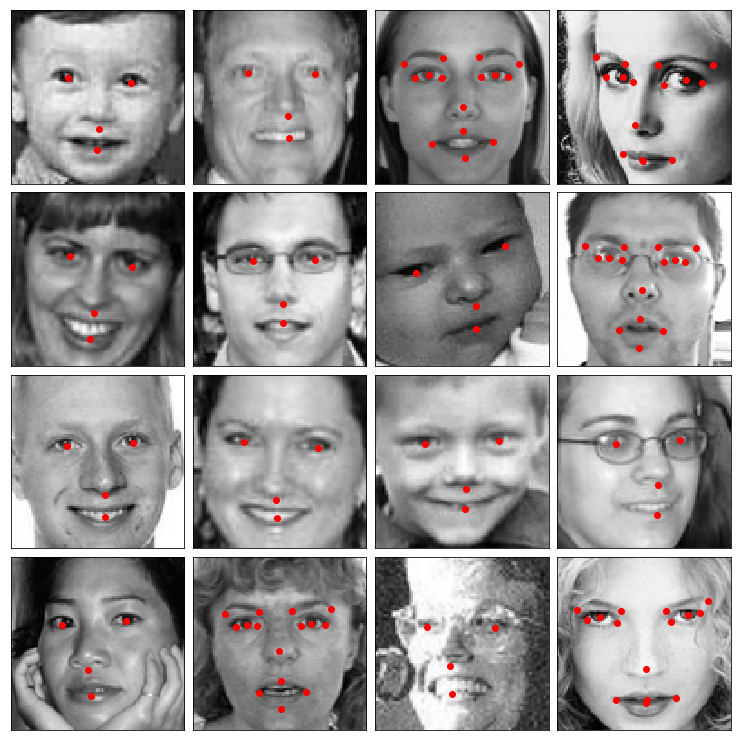

In [18]:
# Output 16 random images. Some of these will be the NA data

idx = np.random.randint(0, len(train_data), 16)
data_sample = train_data[idx, :, :, :]
label_sample = train_labels[idx, :]

plot_sample(data_sample, label_sample)

In [5]:
# move this cell closer to the top, but putting it here now for convenience in referencing for cell below.
i = 0
feature_dict = {}
for label in train.columns.values:
    feature_dict[label] = i
    i += 1
print(feature_dict)

{'left_eye_center_x': 0, 'left_eye_center_y': 1, 'right_eye_center_x': 2, 'right_eye_center_y': 3, 'left_eye_inner_corner_x': 4, 'left_eye_inner_corner_y': 5, 'left_eye_outer_corner_x': 6, 'left_eye_outer_corner_y': 7, 'right_eye_inner_corner_x': 8, 'right_eye_inner_corner_y': 9, 'right_eye_outer_corner_x': 10, 'right_eye_outer_corner_y': 11, 'left_eyebrow_inner_end_x': 12, 'left_eyebrow_inner_end_y': 13, 'left_eyebrow_outer_end_x': 14, 'left_eyebrow_outer_end_y': 15, 'right_eyebrow_inner_end_x': 16, 'right_eyebrow_inner_end_y': 17, 'right_eyebrow_outer_end_x': 18, 'right_eyebrow_outer_end_y': 19, 'nose_tip_x': 20, 'nose_tip_y': 21, 'mouth_left_corner_x': 22, 'mouth_left_corner_y': 23, 'mouth_right_corner_x': 24, 'mouth_right_corner_y': 25, 'mouth_center_top_lip_x': 26, 'mouth_center_top_lip_y': 27, 'mouth_center_bottom_lip_x': 28, 'mouth_center_bottom_lip_y': 29, 'Image': 30}


[2153, 2129, 1505, 4832, 5416, 2432, 4971, 4295, 4759, 127, 914, 1864, 1513, 4029, 3926, 4810]


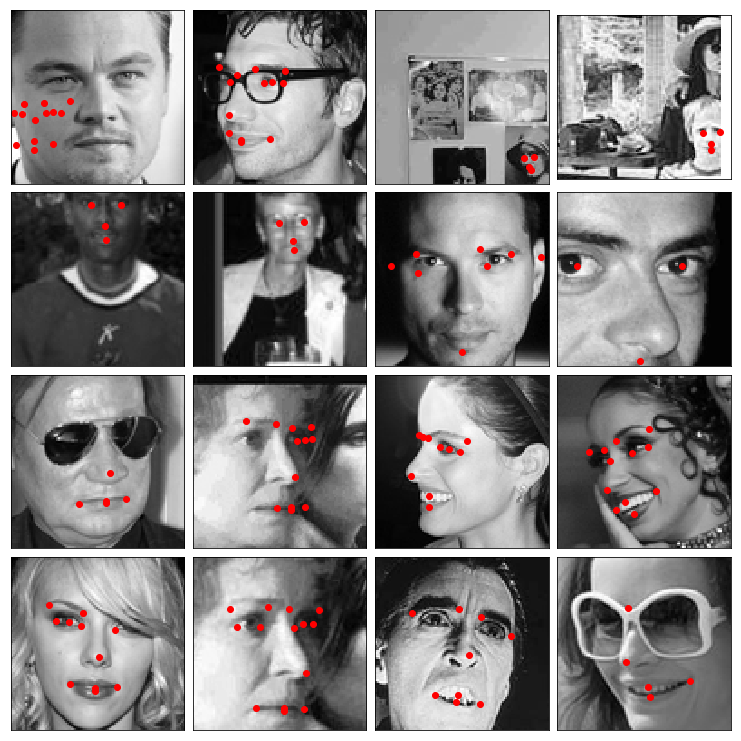

In [17]:
# In addition to random faces, let's check out some edge cases

edge_cases = []

# additional interesting cases to explore if time allows:
# - multiple faces in one image
# - upside down faces
# - incomplete faces (not all key points present)
# - race/lighting (average shade of pixels in facial region, plot couple darkest/lightest)
# - faces halfway offscreen/covered (could try one eye present, one not), image 154 has eyes and nose but mouth offscreen
# - additonal edge cases discovered incidentally 
#    - sunglasses (1802)

#  - eventually will want to manually remove 2153, 4971 is questionable depending on which points those are

# compile interesting cases
edge_cases.extend(train_labels[:,feature_dict['nose_tip_x']].argsort()[:2])           # noses near left of screen
edge_cases.extend(train_labels[:,feature_dict['nose_tip_x']].argsort()[-2:])          # noses near right of screen
edge_cases.extend(train_labels[:,feature_dict['nose_tip_y']].argsort()[:2])           # noses near top of screen
edge_cases.extend((train_labels[:,feature_dict['right_eye_center_x']] -
                   train_labels[:,feature_dict['left_eye_center_x']]).argsort()[:2])  # wide faces
edge_cases.extend((train_labels[:,feature_dict['right_eye_center_x']] -
                   train_labels[:,feature_dict['left_eye_center_x']]).argsort()[-8:]) # small faces
edge_cases.extend((train_labels[:,feature_dict['right_eye_center_x']] -
                   train_labels[:,feature_dict['left_eye_center_x']]).argsort()[-8:]) # small faces

print(edge_cases)

data_edge = train_data[edge_cases, :, :, :]
label_edge = train_labels[edge_cases, :]

plot_sample(data_edge, label_edge)

## Features 

### Engineering: Mirror images

Need the column headers for the labels as an input so this needs to be included in the data load. This takes the data in shape (X, 96, 96, 1) and the labels as (X, 30) numpy arrays.

In [22]:
def flip_data(data, labels, features):
    '''This function flips the images and labels to their new columns
    Input data is numpy array of shape (X, 96, 96, 1)
    Input labels is numpy array of shape (X, 30)
    features is a list of column header strings
    '''
    
    # flip the images
    data_flipped = data[:, :, ::-1, :]
    
    # flip the labels
    labels_flipped = np.zeros(labels.shape)
    for idx in range(len(labels)):
        for i,s1 in enumerate(features):
            parts = s1.partition('_')
            if parts[0] == 'left' or parts[0] == 'right':
                coord = parts[-1]
            elif parts[0] == 'mouth':
                parts = s1.split('_', maxsplit=2)
                if 'corner' in parts[-1]:
                    coord = parts[-1]        
                elif 'x' in parts[-1]:
                    labels_flipped[idx,i] = labels[idx,i] * -1
                else:
                    labels_flipped[idx,i] = labels[idx,i]
            else:
                if 'x' in parts[-1]:
                    labels_flipped[idx,i] = labels[idx,i] * -1
                else:
                    labels_flipped[idx,i] = labels[idx,i]
            for j in range(i+1,len(features)-1):
                s2 = features[j]
                if coord in s2:
                    if 'x' in coord:
                        labels_flipped[idx,i] = labels[idx,j] * -1
                        labels_flipped[idx,j] = labels[idx,i] * -1
                    else:
                        labels_flipped[idx,i] = labels[idx,j]
                        labels_flipped[idx,j] = labels[idx,i]
                
    return data_flipped, labels_flipped

In [23]:
# From here: https://en.wikipedia.org/wiki/Normalization_(image_processing)
def normalize_image(data):
      
    new_dataset = []
    
    for image in data:
        old_min, old_max = np.amin(image), np.amax(image)        
        new_min, new_max = 0, 255

        new_image = []
        
        for pixel in image:
            new_pixel = int((pixel-old_min)*((new_max-new_min)/(old_max-old_min))+ new_min)
            new_image.append(new_pixel)
        
        new_dataset.append(new_image)
        
    new_series = pd.Series(data=new_dataset, index=data.index)
    
    return new_series

train_data = normalize_image(train_data)
test_data = normalize_image(test_data)

TypeError: only size-1 arrays can be converted to Python scalars

In [24]:
def augment_images(data, labels, aug):
    
    aug_data = []
    aug_labels =[]
    
    for image, features in zip(data, labels):
        
        seq_det = seq.to_deterministic()
        image = np.expand_dims(image, axis=0)
        images_aug = np.squeeze(seq_det.augment_images(image))
        
        aug_data.append(images_aug)

        keypoints_on_images = []
        keypoints = []
        
        for c in range(0, features.shape[0], 2):
            x = features[c]* 48 + 48
            y = features[c+1]* 48 + 48

            keypoints.append(ia.Keypoint(x=x, y=y))

        keypoints_on_images.append(ia.KeypointsOnImage(keypoints, shape=(96,96)))
        keypoints_aug = seq_det.augment_keypoints(keypoints_on_images)
        
        aug_labels_set = []
        
        for keypoints_after in keypoints_aug:
            for i, keypoint in enumerate(keypoints_after.keypoints):
                aug_labels_set.append((keypoint.x - 48) / 48)
                aug_labels_set.append((keypoint.y - 48) / 48)
                
        aug_labels.append(aug_labels_set)
        
    return aug_data, np.array(aug_labels)

aug = iaa.Sequential([
    
    iaa.Crop(px=(0, 16))
                     
])

crop_data, crop_labels = augment_images(train_data, train_labels, aug)

NameError: name 'seq' is not defined

In [25]:
# Test for augmentation
plt.figure()
plt.imshow(crop_data[111], cmap='gray')

for c in range(0, crop_labels.shape[1], 2):
    x = crop_labels[111][c]* 48 + 48
    y = crop_labels[111][c+1]* 48 + 48
        
    plt.scatter(x,y,cmap='pastel1')

NameError: name 'crop_data' is not defined

<Figure size 432x288 with 0 Axes>

### Inserting new data into existing

In [26]:
train_data_flipped, train_labels_flipped = flip_data(
    train_data, train_labels, list(features)
)

In [27]:
train_data_set = np.concatenate((train_data, train_data_flipped), axis=0)
train_labels_set = np.concatenate((train_labels, train_labels_flipped), axis=0)
train_data_set.shape, train_labels_set.shape

((11278, 96, 96, 1), (11278, 30))

## Modeling

### Simple Models

In [ ]:
# Naive baseline - calculate the average (X, Y) of all the labels and guess that every time
n_rows = train_data.shape[0]
n_cols = train_data.iloc[0].shape[0]

for col in [1]: #range(n_cols):
    sum = 0
    for row in range(n_rows):
        sum += train_labels.iloc[row][col]
    avg = sum / n_rows
    predictions = np.ones(dev_data.shape[0]) * avg

    mse = mean_squared_error(dev_labels['left_eye_center_x'], predictions)
    print(mse)

In [ ]:
# More simple baselines
regressors = {
    'LinearRegression': LinearRegression(),
    'DecisionTree': DecisionTreeRegressor(),
    'NearestNeighbors': KNeighborsRegressor()
} 

def model_training(model):
    
    # Convert arrays of arrays to a numpy matrix or sklearn .fit doesn't like them.
    X = np.empty((train_data.shape[0], train_data.iloc[0].shape[0]))
    for row in range(train_data.shape[0]):
        X[row,:] = train_data.iloc[row]
    Z = np.empty((dev_data.shape[0], dev_data.iloc[0].shape[0]))
    for row in range(dev_data.shape[0]):
        Z[row,:] = dev_data.iloc[row]
        
    Y = train_labels['left_eye_center_x']
        
    model.fit(X,Y)
    predictions = model.predict(Z)
    
    mse = mean_squared_error(dev_labels['left_eye_center_x'], predictions)
    
    return mse

for k,v in regressors.items():
    print(k,':',model_training(v))

In [ ]:
# Try Simple Single Hidden Layer (800 node) Neural Net Model (Madeline, Alex):

"""
"""

### Building the Neural Network
The default values I have defined do not need to stay here they can be whatever and will probably change once we run a proper grid search

In [9]:
def mean_squared_error_with_missing(y_true, y_pred):
    
    # figure out which labels are present
    present = tf.logical_not(tf.is_nan(y_true))
    
    # select only those labels
    present_labels_true = tf.boolean_mask(y_true, present)
    present_labels_pred = tf.boolean_mask(y_pred, present)
    
    
    # compute mean squared error
    loss = tf.math.reduce_mean(tf.math.squared_difference(present_labels_true,present_labels_pred))
    
    return loss

In [10]:
def build_CNN(
    num_ConvLayers=3, 
    num_DenseLayers=2,
    filters=[32,64,128],
    kernels=[(3,3), (3,3), (3,3)], 
    pools=[(2,2),(2,2),(2,2)], 
    dense_nodes=[1000,1000], 
    optimizer=keras.optimizers.Adam(), 
    dropout=None,
    input_shape=(96,96,1)
):
    '''This function builds a CNN model
    num_ConvLayers --> is the number of convolutional layer groups where 
    each group contains a convolutional layer, a pooling layer, and an
    optional dropout layer
    
    num_DenseLayers --> is the number of dense layers after flattening
    the convolutional output
    
    filters --> a list of the number of filters used in each
    convolutional layer specified in num_ConvLayers
    
    kernels --> a list of the kernel size to use in each convolutional
    layer specified in num_ConvLayers
    
    pools --> a list of the kernel size to use in each pooling layer
    specified in num_ConvLayers
    
    dense_nodes --> a list of the number of units in each dense layer
    specified in num_DenseLayers
    
    dropout --> optional, a list of the dropout rates at each 
    convolutional layer
    
    input_shape --> the shape of the input data
    '''
    # define a Sequential model
    model = Sequential()
    
    # add convolutional layer groups
    for i in range(num_ConvLayers):
        model.add(Conv2D(
            filters=filters[i],
            kernel_size=kernels[i],
            strides=(1,1),
            padding='same',
            activation='relu',
            input_shape=input_shape
        ))
        model.add(MaxPooling2D(
            pool_size=pools[i],
            strides=None
        ))
        
        # add dropout layers if specified
        if dropout:
            model.add(Dropout(rate=dropout[i]))
    
    # flatten the convolutional layers
    model.add(Flatten())
    
    # add the dense layers
    for j in range(num_DenseLayers):
        model.add(Dense(
            units=dense_nodes[j],
            activation='relu'
        ))
        
    # create the output layer
    model.add(Dense(units=30))
    
    # compile the model
    #model.compile(loss='mean_squared_error', optimizer=optimizer)
    model.compile(loss=mean_squared_error_with_missing, optimizer=optimizer)
    
    return model

#### Time callback so we can easily see total train time of each iteration of model

In [11]:
class TimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

#### Function to Plot the neural net flow

In [12]:
def plot_NN(model):
    plot_model(model, to_file='model.png', show_shapes=True)
    mod = plt.imread('model.png')
    fig = plt.figure(figsize=(10,20), frameon=False)
    plt.imshow(mod)
    plt.axis('off')

## Grid Search

In [ ]:
# Define the model as a KerasRegressor class

model = KerasRegressor(build_fn=build_CNN, epochs=10)

# Define parameter ranges over which to search

f = list(range(8,72,8))
filts = [[i, i*2, i*4] for i in f]
filts, len(filts)

optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']

k1 = [[(i,i)]*3 for i in range(2,5)]
k2 = [
    [(4,4), (3,3), (2,2)], 
    [(3,3), (2,2), (2,2)], 
    [(2,2), (3,3), (4,4)],
    [(2,2), (2,2), (3,3)],
    [(3,3), (3,3), (2,2)],
    [(2,2), (3,3), (3,3)],
]
k = k1 + k2
k, len(k)

# param_grid = dict(optimizer=optimizer, filters=filts, kernels=k)
# param_grid = dict(optimizer=optimizer, kernels=k)
param_grid = dict(kernels=k)
param_grid

# Run the grid search

grid = GridSearchCV(
    estimator=model, 
    param_grid=param_grid, 
#     n_jobs=-1,
    scoring='neg_mean_squared_error',
)

grid_data, grid_labels = shuffle(train_data_set, train_labels_set, random_state=666)
grid_data, grid_labels = grid_data[:100], grid_labels[:100]
grid_data.shape, grid_labels.shape

grid_result = grid.fit(grid_data, grid_labels, verbose=1)

# Get the results and store to csv

cv_results = pd.DataFrame(grid_result.cv_results_)
cv_results.head()
cv_results.to_csv('grid_search_results2.csv')
grid_result.best_params_

###  Running CNN
I think we discussed building a CNN with a set of default parameters, train it on the original data set, then augment the data and train it again, then change some parameters in the model and train it again, etc

<table> 
<tr>
<th> Model Name </th> <th> Model Parameters </th> <th> Training Criteria </th>
</tr>
<tr>
<td> Model 1a </td> <td> Default </td> <td> 10 epochs, 100 data points </td>
</tr>
    <tr>
<td> Model 1b </td> <td> Default </td> <td> 10 epochs, Original data </td>
</tr>
    <tr>
<td> Model 1c </td> <td> Default </td> <td> 10 epochs, Augmented data </td>
</tr>
    <tr>
<td> Model 2a </td> <td> ... </td> <td> ... </td>
</tr>
</table>

#### Model 1a

In [30]:
model1a = build_CNN()

In [ ]:
plot_NN(model1a)

In [35]:
# just using the first 100 points to run it quick and show the visualization
time_callback = TimeHistory()
hist1a = model1a.fit(
    train_data[:100], train_labels[:100], 
    batch_size=32,
    epochs=10, 
    validation_split=0.2, 
#     validation_data = dev_data
    verbose=1,
    callbacks=[keras.callbacks.History(), time_callback]
)
print('\nRMS error on validation set:', np.sqrt(hist1a.history['val_loss'][-1]) * 48)
print('Total runtime (minutes):', round(np.sum(time_callback.times) / 60, 2))

Train on 80 samples, validate on 20 samples
Epoch 1/10
80/80 [==============================] - 3s 33ms/step - loss: 0.0101 - val_loss: 0.0087
Epoch 2/10
80/80 [==============================] - 3s 33ms/step - loss: 0.0083 - val_loss: 0.0106
Epoch 3/10
80/80 [==============================] - 3s 32ms/step - loss: 0.0083 - val_loss: 0.0071
Epoch 4/10
80/80 [==============================] - 3s 33ms/step - loss: 0.0078 - val_loss: 0.0089
Epoch 5/10
80/80 [==============================] - 3s 32ms/step - loss: 0.0081 - val_loss: 0.0083
Epoch 6/10
80/80 [==============================] - 3s 37ms/step - loss: 0.0076 - val_loss: 0.0071
Epoch 7/10
80/80 [==============================] - 3s 33ms/step - loss: 0.0075 - val_loss: 0.0088
Epoch 8/10
80/80 [==============================] - 3s 33ms/step - loss: 0.0070 - val_loss: 0.0073
Epoch 9/10
80/80 [==============================] - 3s 33ms/step - loss: 0.0067 - val_loss: 0.0073
Epoch 10/10
80/80 [==============================] - 3s 32ms/step

We could try running this for longer, but the way the validation loss levels off even as the training loss continues to shrink shows that the model is overfitting. This is unsurprising given the small size of our data set, and the large number of parameters. For better results, we should next try the full (unaugmented) data set and see how it fares.

#### Model 1b

In [36]:
model1b = build_CNN()

In [38]:
time_callback = TimeHistory()
hist1b = model1b.fit(
    train_data, train_labels, 
    batch_size=32,
    epochs=10, 
    validation_split=0.2, 
#     validation_data = dev_data
    verbose=1,
    callbacks=[keras.callbacks.History(), time_callback]
)
print('\nRMS error on validation set:', np.sqrt(hist1b.history['val_loss'][-1]) * 48)
print('Total runtime (minutes):', round(np.sum(time_callback.times) / 60, 2))

Train on 4511 samples, validate on 1128 samples
Epoch 1/10
4511/4511 [==============================] - 134s 30ms/step - loss: 0.0073 - val_loss: 0.0065
Epoch 2/10
4511/4511 [==============================] - 137s 30ms/step - loss: 0.0068 - val_loss: 0.0065
Epoch 3/10
4511/4511 [==============================] - 138s 30ms/step - loss: 0.0067 - val_loss: 0.0063
Epoch 4/10
4511/4511 [==============================] - 139s 31ms/step - loss: 0.0064 - val_loss: 0.0058
Epoch 5/10
4511/4511 [==============================] - 140s 31ms/step - loss: 0.0055 - val_loss: 0.0047
Epoch 6/10
4511/4511 [==============================] - 140s 31ms/step - loss: 0.0046 - val_loss: 0.0041
Epoch 7/10
4511/4511 [==============================] - 140s 31ms/step - loss: 0.0042 - val_loss: 0.0038
Epoch 8/10
4511/4511 [==============================] - 139s 31ms/step - loss: 0.0039 - val_loss: 0.0037
Epoch 9/10
4511/4511 [==============================] - 138s 31ms/step - loss: 0.0036 - val_loss: 0.0035
Epoch 1

This did significantly better and the validation loss was still improving alongside the training loss at the end of ten epochs. Given this continued improvement, it would be worth running this for longer.

In [49]:
time_callback = TimeHistory()
hist1bcont = model1b.fit(
    train_data, train_labels, 
    batch_size=32,
    epochs=10, 
    validation_split=0.2, 
#     validation_data = dev_data
    verbose=1,
    callbacks=[keras.callbacks.History(), time_callback]
)
print('\nRMS error on validation set:', np.sqrt(hist1bcont.history['val_loss'][-1]) * 48)
print('Total runtime (minutes):', round(np.sum(time_callback.times) / 60, 2))

Train on 4511 samples, validate on 1128 samples
Epoch 1/10
4511/4511 [==============================] - 133s 30ms/step - loss: 0.0023 - val_loss: 0.0030
Epoch 2/10
4511/4511 [==============================] - 142s 31ms/step - loss: 0.0022 - val_loss: 0.0031
Epoch 3/10
3104/4511 [===================>..........] - ETA: 43s - loss: 0.0019

KeyboardInterrupt: 

#### Model 1c

In [39]:
model1c = build_CNN()

In [40]:
# train the model with combined data set of original and 
# augmented images. 
# to just using 200 points here for speed:
#idx = np.random.randint(0, len(train_data_set), 200)
# train_data_set[idx], train_labels_set[idx]

time_callback = TimeHistory()
hist1c = model1c.fit(
    train_data_set, train_labels_set,
    batch_size=32,
    epochs=10, 
    validation_split=0.2, 
#     validation_data = dev_data_set
    verbose=1,
    callbacks=[keras.callbacks.History(), time_callback]
)
print('\nRMS error on validation set:', np.sqrt(hist1c.history['val_loss'][-1]) * 48)
print('Total runtime (minutes):', round(np.sum(time_callback.times) / 60, 2))

Train on 9022 samples, validate on 2256 samples
Epoch 1/10
 736/9022 [=>............................] - ETA: 4:21 - loss: 4.0577

KeyboardInterrupt: 

#### Model 2

In [ ]:
# augment some data or change a parameter
model2 = build_CNN()
plot_NN(model2)

#### Visualize training improvement
Doesn't look like an improvement, but it will once we train on the whole data sets

In [ ]:
val_rms1 = np.sqrt(hist1.history['val_loss']) * 48
train_rms1 = np.sqrt(hist1.history['loss']) * 48
val_rms2 = np.sqrt(hist2.history['val_loss']) * 48
train_rms2 = np.sqrt(hist2.history['loss']) * 48

plt.plot(val_rms1, 'g-')
plt.plot(train_rms1, 'b-')
plt.plot(val_rms2, 'g--')
plt.plot(train_rms2, 'b--')
plt.legend([
    'val loss - model 1','training loss - model 1',
    'val loss - model 2','training loss - model 2'
])

#### Seeing how well 4 epochs predicts...

In [ ]:
test_data, test_labels = load_data(test=True)

In [ ]:
pred = model.predict(test_data)
pred[0]

In [ ]:
idx = np.random.randint(0, len(test_data), 16)
test_sample = test_data[idx, :, :, :]
pred_sample = pred[idx, :]

In [ ]:
plot_sample(test_sample, pred_sample)

Looks like after 4 epochs, it is just plotting the very similar points for each image because it hasn't learned a lot. Nouri trains his CNN for 1000 epochs...going to take a long time

#### Kaggle Output

In [50]:
#Predict values for your chosen model
pred = model1b.predict(test_data)

In [53]:
# Get the list of required test points
lookup = pd.read_csv('IdLookupTable.csv')

In [61]:
#Match up the test points with the predicted values

labelNums = {}
for index, label in enumerate(train.columns.values):
    labelNums[label] = index
    
lookup['FeatureNum'] = lookup.apply(lambda row: labelNums[row['FeatureName']], axis=1)
lookup.Location =  np.minimum(96,np.maximum(0,pred[lookup.ImageId-1,lookup.FeatureNum]*48 + 48))

In [62]:
# save the rowid and the associated location to a csv

lookup.to_csv(path_or_buf='kagglesubmission.csv',columns=['RowId','Location'],index=False)

To submit, run:
kaggle competitions submit -c facial-keypoints-detection -f submission.csv -m "Message"

## Conclusion

Put a conclusion here comparing and contrasting the models and how well we did on Kaggle

## Appendix

### Daniel Nouri model transferred to Keras (as best as I could)

In [ ]:
# making a callback so I can compare runtimes
class TimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

In [ ]:
model = Sequential()

# first group of layers
model.add(Conv2D(
    32, 
    kernel_size=(3,3), 
    activation='relu',
    input_shape=(96, 96, 1), 
#     data_format='channels_first'
))
model.add(MaxPooling2D(pool_size=(2, 2)))

# second group of layers
model.add(Conv2D(
    64, 
    kernel_size=(2, 2), 
    activation='relu'
))
model.add(MaxPooling2D(pool_size=(2, 2)))

# third group of layers
model.add(Conv2D(
    128, 
    kernel_size=(2, 2), 
    activation='relu'
))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(500, activation='relu'))
model.add(Dense(500, activation='relu'))
model.add(Dense(30))

sgd = keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='mean_squared_error', optimizer=sgd)

In [ ]:
time_callback = TimeHistory()
hist = model.fit(
    train_data, train_labels, 
    batch_size=32,
    epochs=4,
    validation_split=0.2, 
    verbose=1,
    callbacks=[keras.callbacks.History(), time_callback]
)
print('RMS error on validation set:', np.sqrt(hist.history['val_loss'][-1]) * 48)
print('Total runtime (minutes):', round(np.sum(time_callback.times) / 60, 2))

### Alex trying to understand...

In [ ]:
model = Sequential()

# FIRST CONVOLUTIONAL LAYER
model.add(Conv2D(
    filters=32, # don't yet fully understand how to choose this dimension
    kernel_size=(3,3),
    strides=(1,1),
    padding='same',
    activation='relu',
    input_shape=(96, 96, 1),
))
# input_shape = (batch, rows, cols, channels) --> (batch, 96, 96, 1)
# padding = 'same' so for a kernel of size (3,3) and strides=(1,1) this 
# will pad two rows and two columns of zeros on the edges so that the 
# output shape gives an tensor with 96 rows and 96 columns
# output_shape = (batch, new_rows, new_cols, filters) --> (batch, 96, 96, 32)

# POOLING LAYER
model.add(MaxPooling2D(
    pool_size=(2,2),
    strides=None
))
# setting strides=None sets the strides to a default of pool_size, so 
# here we are really setting strides=(2,2) which is what we want so we 
# don't miss any pixels and we don't count any pixels more than once
# the strides is essentially the factor by which to downscale the output
# so setting the strides=(2,2) will have the dimensions of input
# output_shape = (batch, in_rows/strides[0], in_cols/strides[1], filters) --> (batch, 48, 48, 32)


# SECOND CONVOLUTIONAL LAYER
model.add(Conv2D(
    filters=64, # don't know why we increased this number by 2
#     kernel_size=(2, 2),
    kernel_size=(3, 3),
    strides=(1,1),
    padding='same',
    activation='relu'
))
# input_shape = (batch, pool_rows, pool_cols, in_filters) --> (batch, 48, 48, 32)
# output_shape = (batch, new_rows, new_cols, out_filters) --> (batch, 48, 48, 64)

# SECOND POOLING LAYER
model.add(MaxPooling2D(
    pool_size=(2, 2), 
    strides=None
))
# input_shape = (batch, in_rows, in_cols, filters) --> (batch, 48, 48, 64)
# output_shape = (batch, in_rows/strides[0], in_cols/strides[1], filters) --> (batch, 24, 24, 64)

# THIRD CONVOLUTIONAL LAYER
model.add(Conv2D(
    filters=128, # don't know how to choose this value
#     kernel_size=(2, 2),
    kernel_size=(3, 3),
    strides=(1,1),
    padding='same',
    activation='relu'
))
# input_shape = (batch, pool_rows, pool_cols, in_filters) --> (batch, 24, 24, 64)
# output_shape = (batch, new_rows, new_cols, out_filters) --> (batch, 24, 24, 128)

# THIRD POOLING LAYER
model.add(MaxPooling2D(
    pool_size=(2, 2),
    strides=None
))
# input_shape = (batch, in_rows, in_cols, filters) --> (batch, 24, 24, 128)
# output_shape = (batch, in_rows/strides[0], in_cols/strides[1], filters) --> (batch, 12, 12, 128)

# FLATTEN THE POOLED OUTPUT TO CLASSIFY
model.add(Flatten())
# flatten the output into a single layer of 
#     shape = [batch, pool_rows * pool_cols * in_filters]
#         --> [batch, 12 * 12 * 128] = [batch, 18432]

# ADD ONE FULLY CONNECTED LAYER TO PROCESS THE FLATTENED DATA
model.add(Dense(
#     500,
    1000,
    activation='relu'
))
# input_shape = [batch, flattened_nodes] = [batch, 18432]
# output_shape = [batch, out_nodes] = [batch, 500]

# FINAL OUTPUT LAYER
model.add(Dense(30))
# input_shape = [batch, in_nodes] = [batch, 500]
# output_shape = [batch, num_classes] = [batch, 30]

# sgd = keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
adam = keras.optimizers.Adam()
model.compile(loss='mean_squared_error', optimizer=Adam)

In [ ]:
time_callback = TimeHistory()
hist = model.fit(
    train_data, train_labels, 
    batch_size=32,
    epochs=4, 
    validation_split=0.2, 
    verbose=1,
    callbacks=[keras.callbacks.History(), time_callback]
)
print('\nRMS error on validation set:', np.sqrt(hist.history['val_loss'][-1]) * 48)
print('Total runtime (minutes):', round(np.sum(time_callback.times) / 60, 2))

Changed the kernel size in the second two layers to (3,3), almost doubled the training time, didn't improve the error by a lot